In [2]:
from datetime import datetime
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import sys
sys.path.append(r'C:\Users\ruro\OneDrive - Boskalis\Documents\python\01-Fieldwork\Pressure_sensors\RBR')
from KNMI_readers import read_knmi_uurgeg
import puv
from IPython.display import clear_output


In [3]:
def solo_data_reader(dataFile, sf):
    '''
    Function to read solo datafile.
    Returns a dataframe with a time column and pressure column in Pascal
    '''
    p = []
    datt = []
    with open(dataFile) as myfile:
        for index, line in enumerate(myfile):
            if index >= 1:
                lin = line.split(',')
                datt.append(lin[0])
                p.append(float(lin[1]))
    p = np.array(p) * 1e4  # dBar to Pa

    t = pd.date_range(datt[0], periods=len(datt), freq='{}S'.format(1 / sf))

    dfp = pd.DataFrame(data={'p': p}, index=t)

    dfp.index.name = 't'
    return dfp

In [4]:
experimentFolder = r'C:\Users\ruro\OneDrive - Boskalis\Documents\python\01-Fieldwork\Pressure_sensors\RBR\RBR_data'
sf = 8                                                                                                  #[hz] sampling frequency

fresolution = 0.03125
rho = 1028
g = 9.8
zb = -0.5
zi =  -0.38
knmiFile = r'C:\Users\ruro\OneDrive - Boskalis\Documents\python\RDR\uurgeg_235_2021-2030.txt'

#  could be excel .csv

folder_Names = ['RBR_01', 'RBR_02', 'RBR_05', 'RBR_06']
instrument_Names = ['Solo_RBR_01', 'Solo_RBR_02', 'Solo_RBR_05', 'Solo_RBR_06']
namedata_Files = ['202438_20240927_1934_RBR1_data.txt', '202439_20240927_1941_RBR2_data.txt', '208681_20240927_1957_RBR5_data.txt', '208682_20240927_1947_RBR6_data.txt']
serial_Numbers = ['202438', '202439', '208681', '208682']
xRD_list = ['72410.295', '72410.295', '72410.295', '72410.295']
yRD_list = ['450987.764', '450987.764', '450987.764', '450987.764']

In [ ]:
for i in range(len(folder_Names)):
    clear_output(True)
    print(f'this is loop {i+1} ')
### Input parameters###
    dataFile =  os.path.join(experimentFolder, folder_Names[i], namedata_Files[i])
    sf=8                                                                                                              #[hz] sampling frequency, needs to reset every loop / change to array if different sf 
    instrumentName = instrument_Names[i]
    serial_number = serial_Numbers[i]                                                                                 # unique serial number of the instrument
    xRD = xRD_list[i]                                                                                                 # x position of placement in field
    yRD = yRD_list[i]                                                                                                 # y position of placement in field
                                                                                                
###Raw Data###
    #do the reading from file and cast in xarray dataset
    print("converting Raw data")
    print(dataFile)
    dfp = solo_data_reader(dataFile,sf)
    ds = dfp.to_xarray()
    ds.p.attrs = {'long_name': 'pressure', 'units': 'Pa'}

    # add global attribute metadata
    ds.attrs = {
        'Conventions': 'CF-1.6',
        'name': '{}'.format(instrumentName),
        'instrument': '{}'.format(instrumentName),
        'instrument type': 'Ruskin RBR Solo',
        'instrument serial number': '{}'.format(serial_number),
        'epsg': 28992,
        'x': xRD,
        'y': yRD,
        'time zone': 'UTC+2',
        'coordinate type': 'XYZ',
        'summary': 'Hybrid-Dune field campaign',
        'contact person': 'Ruben Rosman',
        'emailadres': 'r.g.c.rosman@student.tudelft.nl',
        'construction datetime': datetime.now().strftime("%d-%b-%Y (%H:%M:%S)"),
        'version': 'v1',
        'version comments': 'constructed with xarray'}

    # save to netcdf
    ncOutDir = os.path.join(experimentFolder, folder_Names[i], 'raw_netcdf')
    if not os.path.isdir(ncOutDir):
        os.mkdir(ncOutDir )
    ds.to_netcdf(os.path.join(ncOutDir, instrumentName + '.nc'))

### QC ####
    # instrumentName = 'L2C2SOLO.nc'  
    print('converting to QC')
    dataFile = os.path.join(experimentFolder,  folder_Names[i], 'raw_netcdf', instrumentName +'.nc')
    print(dataFile)
    ds0 = xr.open_dataset(dataFile)
    instr = ds0.instrument

    # correct for the air pressure fluctuations and drift in the instrument
    # first we load the data and add it to the dataset
    dfp = read_knmi_uurgeg(knmiFile, stationNumber=235)
    dt = ((ds0.t[1] - ds0.t[0]) / np.timedelta64(1, 's')).values # target frequency
    pAir = dfp['P'].to_xarray().sel(t=slice(ds0.t.min(), ds0.t.max())).resample({'t': '{}S'.format(dt)}).interpolate('linear')
    ds0['pAir'] = pAir.sel(t=slice(ds0.t.min(), ds0.t.max()))

    # we correct for drift in air pressure, nothing else
    ds0['dpAir'] = ds0['pAir'] - ds0['pAir'].isel(t=0)

    # correct the pressure signal with dpAir and with drift in instrument pressure
    ds0['pc'] = ds0['p'] -ds0['p'].min() - ds0['dpAir']
    ds0['pc'].attrs = {'units': 'Pa + NAP', 'long_name': 'pressure', 'comments': 'drift in air pressure is corrected'}

    # -----------------------------------------------------------------------------
    # reshape to one row per burst in data array
    pt = ds0.pc.values
    nSamples = len(pt)
    dt = ds0.isel(t=1).t - ds0.isel(t=0).t
    sf = np.timedelta64(1, 's') / dt.values

    burstDuration = pd.Timedelta('600S')  #sampling block 
    burstLength = int(burstDuration / dt)
    nBursts = int(np.floor(nSamples / burstLength))

    pt = pt[:nBursts * burstLength]
    t = ds0.t[::burstLength]
    t = t[:nBursts]
    N = (ds0.t.values[:burstLength] - ds0.t.values[0]) / np.timedelta64(1, 's')
    # pdb.set_trace()

    # --------------------------------------------------------------------------
    # cast into a 2D array
    ds = xr.Dataset(data_vars={},
                    coords={'t': t, 'N': N})
    # copy all data over into this new structure
    ds['p'] = (('t', 'N'), pt.reshape((nBursts, burstLength)))
    ds['zi'] = zi
    ds['zb'] = zb
    ds['sf'] = sf


    # remove all bursts where instrument fell dry
    ds['p'] = ds.p.where(ds.p.std(dim='N') > 70)

    # --------------------------------------------------------------------------
    # pdb.set_trace()
    ds['p'].attrs = {'units': 'Pa +NAP', 'long_name': 'pressure', 'comments': 'corrected for air pressure'}
    ds['zi'].attrs = {'units': 'm+NAP', 'long_name': 'zi'}
    ds['zb'].attrs = {'units': 'm+NAP', 'long_name': 'zb'}
    ds['sf'].attrs = {'units': 'Hz', 'long_name': 'sampling frequency'}
    ds.attrs = ds0.attrs
    ds.attrs['summary'] = 'SEDMEX field campaign, pressure corrected for air pressure and cast in bursts of 10 minutes'
    ds['name'] = instr
    if not os.path.isdir(os.path.join(experimentFolder, folder_Names[i], 'QC')):
        os.mkdir(os.path.join(experimentFolder, folder_Names[i], 'QC'))
    ncFilePath = os.path.join(experimentFolder, folder_Names[i] , 'QC', instr + '.nc')
    ds.to_netcdf(ncFilePath)

# # ### Compute waves###
    print('Computing waves')
    # %% input specification
    # experimentFolder = r'C:\Users\ruro\OneDrive - Boskalis\Documents\python\RDR\RDR02_data'
    # instrumentName = 'L2C2SOLO.nc' 
    instrFile = os.path.join(experimentFolder, folder_Names[i],'QC', instrumentName+'.nc')
    ncOutFile = os.path.join(experimentFolder, folder_Names[i],'tailored', instrumentName+'.nc')

    # frequency resolution in fourier space
    fresolution = 0.03125
    rho = 1025
    g = 9.8

    # %% load the raw data from netcdf
    ds0 = xr.open_dataset(instrFile)

    #let's remove the bursts where there are only nans
    ds0 = ds0.dropna(dim='t')

    # make a new dataset that has an extra dimension to accomodate for the frequency axis
    ds = xr.Dataset(data_vars={},
                    coords={'t': ds0.t.values,
                            'N': ds0.N.values,
                            'f': np.arange(0, ds0.sf.values / 2, fresolution)})
    ds['f'].attrs = {'units': 'Hz'}
    ds.attrs = ds0.attrs

    # put all variables in this new dataset
    for key in ds0.data_vars:
        ds[key] = ds0[key]

    # extract sampling frequency as explicit variable
    sf = ds.f.values

    # compute water depth
    ds['h'] = (ds['p']/rho/g + ds['zi']).mean(dim='N')
    ds['h'].attrs = {'long_name': 'mean water level', 'units': 'm+NAP'}

    # %% do several wave statistics computations, only based on pressure
    ufunc = lambda x, h: puv.attenuation_corrected_wave_spectrum(
        'pressure',
        ds.sf.values, x, h,
        ds.zi.values,
        ds.zb.values,
        fresolution=fresolution)

    fx, ds['vy'] = xr.apply_ufunc(ufunc,
                                ds['p'], ds['h'],
                                input_core_dims=[['N'], []],
                                output_core_dims=[['f'], ['f']],
                                vectorize=True)
    ds['vy'].attrs = {'units': 'm2/Hz', 'long_name': 'spectral density'}

    ufunc = lambda vy: puv.get_peak_frequency(ds.f.values, vy)
    ds['fp'] = xr.apply_ufunc(ufunc,
                            ds['vy'],
                            input_core_dims=[['f']],
                            output_core_dims=[[]],
                            vectorize=True)

    ufunc = lambda vy, fp: puv.compute_wave_params(ds.f.values, vy, fmin=0.5 * fp, fmax=5)
    ds['Hm0'], ds['Tp'], ds['Tm01'], ds['Tm02'], ds['Tmm10'], ds['Tps'] = xr.apply_ufunc(ufunc,
                                                                            ds['vy'], ds['fp'],
                                                                            input_core_dims=[['f'], []],
                                                                            output_core_dims=[[], [], [], [], [], []],
                                                                            vectorize=True)
    ds['Hm0'].attrs = {'units': 'm', 'long_name': 'significant wave height',
                    'computation': 'computed between fmin=0.5fp and fmax=5'}
    ds['Tp'].attrs = {'units': 's', 'long_name': 'peak wave period',
                    'computation': 'computed between fmin=0.5fp and fmax=5'}
    ds['Tm01'].attrs = {'units': 's', 'long_name': 'mean wave period',
                        'computation': 'computed between fmin=0.5fp and fmax=5'}
    ds['Tm02'].attrs = {'units': 's', 'long_name': 'mean wave period',
                        'computation': 'computed between fmin=0.5fp and fmax=5'}
    ds['Tmm10'].attrs = {'units': 's', 'long_name': 'mean wave period',
                        'computation': 'computed between fmin=0.5fp and fmax=5'}
    ds['Tps'].attrs = {'units': 's', 'long_name': 'peak wave period','computation':'computed between fmin=0.5fp and fmax=5', 'comment':'smoothed estimate from the discrete spectrum'}


    # %% write to file
    # we strip all information on burst scale from the dataset to reduce size (and this info is already present in the raw_netcdf version of the data)
    dsTailored = ds.drop_dims('N')
    if not os.path.isdir(os.path.join(experimentFolder,folder_Names[i], 'tailored')):
        os.mkdir(os.path.join(experimentFolder, folder_Names[i], 'tailored'))
    ncFilePath = os.path.join(experimentFolder, folder_Names[i],  'tailored', ds0.instrument + '.nc')
    dsTailored.to_netcdf(ncFilePath)


this is loop 4 
converting Raw data
C:\Users\ruro\OneDrive - Boskalis\Documents\python\01-Fieldwork\Pressure_sensors\RBR\RBR_data\RBR_06\208682_20240927_1947_RBR6_data.txt


C:\Users\ruro\AppData\Local\Temp\ipykernel_13912\2651882304.py:16: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  t = pd.date_range(datt[0], periods=len(datt), freq='{}S'.format(1 / sf))


converting to QC
C:\Users\ruro\OneDrive - Boskalis\Documents\python\01-Fieldwork\Pressure_sensors\RBR\RBR_data\RBR_06\raw_netcdf\Solo_RBR_06.nc


c:\Users\ruro\OneDrive - Boskalis\Documents\python\01-Fieldwork\Pressure_sensors\RBR\KNMI_readers.py:28: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  t0 = pd.to_datetime(knmi.iloc[0]['YYYYMMDD'],format='%Y%m%d')+pd.Timedelta('{}H'.format(knmi.iloc[0]['HH']))
c:\Users\ruro\OneDrive - Boskalis\Documents\python\01-Fieldwork\Pressure_sensors\RBR\KNMI_readers.py:29: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  t = pd.date_range(t0.to_datetime64(),periods=len(knmi),freq='1H')
c:\Users\ruro\AppData\Local\Programs\Python\Python39\lib\site-packages\xarray\groupers.py:326: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  self.index_grouper = pd.Grouper(
C:\Users\ruro\AppData\Local\Temp\ipykernel_13912\1951616507.py:74: FutureWarning: 'S' is deprecated and will be removed in a future version. Please use 's' instead of 'S'.
  burstD

Computing waves


c:\Users\ruro\OneDrive - Boskalis\Documents\python\01-Fieldwork\Pressure_sensors\RBR\puv.py:52: RuntimeWarning: invalid value encountered in power
  q = w2 / (1-np.exp(-w2**(5/4)))**(2/5)
c:\Users\ruro\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\_function_base_impl.py:2531: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  output[index] = result


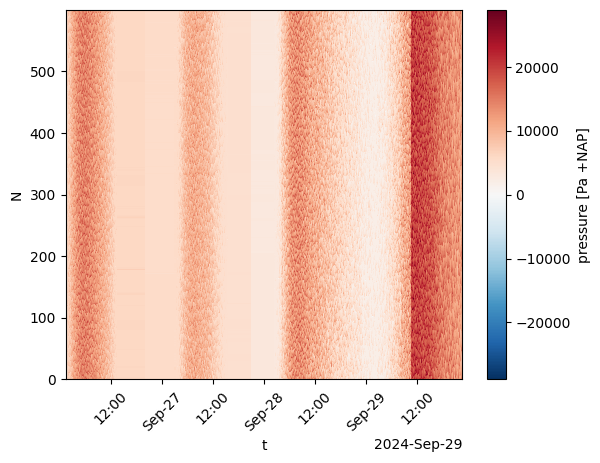

In [6]:
ds['p'].transpose().plot()
# ds['p'].plot()
plt.xticks(rotation=45);

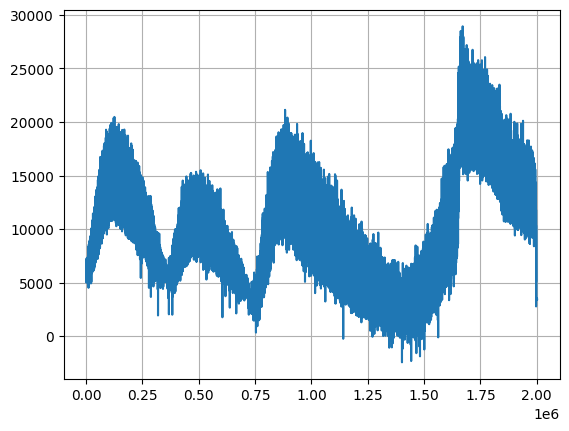

In [13]:
plt.plot(ds['p'].values.flatten())
# plt.plot(ds.t, ds.p.mean(dim='N'))
# plt.scatter(ds['t'], ds['p']) #not same array sizes
plt.grid()
# plt.xticks(rotation=45)
# plt.legend()